In [ ]:
import numpy as np
def disecret(listA):
    avg = np.mean(listA)
    for idx in range(len(listA)):
        if listA[idx] > avg:
            listA[idx] = 1
        else:
            listA[idx] = 0
    
    return listA

In [ ]:
def jaccard_distance(setA, setB):
    # Convert lists to sets if they are not
    if not isinstance(setA, set):
        setA = set(setA)
    if not isinstance(setB, set):
        setB = set(setB)
    
    # Calculate the size of the intersection of setA and setB
    intersection_size = len(setA & setB)
    
    # Calculate the size of the union of setA and setB
    union_size = len(setA | setB)
    
    # Calculate Jaccard Similarity
    jaccard_similarity = intersection_size / float(union_size)
    
    # Calculate Jaccard Distance
    jaccard_distance = 1.0 - jaccard_similarity
    
    return jaccard_distance

def jaccard_distance_list(listA, listB):
    listA = zip(range(len(listA)), listA)
    listB = zip(range(len(listB)), listB)
    
    # Convert lists to sets if they are not
    if not isinstance(listA, set):
        setA = set(listA)
    if not isinstance(listB, set):
        setB = set(listB)

    
    # Calculate the size of the intersection of setA and setB
    intersection_size = len(setA & setB)
    
    # Calculate the size of the union of setA and setB
    union_size = len(setA | setB)
    
    # Calculate Jaccard Similarity
    jaccard_similarity = intersection_size / float(union_size)
    
    # Calculate Jaccard Distance
    jaccard_distance = 1.0 - jaccard_similarity
    
    return jaccard_distance


In [ ]:
import torch
import torch.nn as nn

def layer_weights_to_list(layer):
    # Extract the weight tensor from the layer
    weight_tensor = layer.weight.data
    
    # Flatten the weight tensor into a 1D tensor
    weight_flat = weight_tensor.flatten()
    
    # Convert the 1D tensor into a Python list
    weight_list = weight_flat.tolist()
    
    # # Convert the list into a set
    # weight_set = list(weight_list)
    
    return weight_list



In [ ]:

# Example: Create a simple linear layer with 2 input features and 3 output features
linear_layer_1 = nn.Linear(2, 3)
linear_layer_2 = nn.Linear(2, 3)

# Convert the layer weights to a set
weight_set_1 = layer_weights_to_list(linear_layer_1)
print("Weight Set:", weight_set_1)
weight_set_2 = layer_weights_to_list(linear_layer_2)
print("Weight Set:", weight_set_2)


In [ ]:
weight_set_dis_1 = disecret(weight_set_1)
print("Weight Set:", weight_set_dis_1)
weight_set_dis_2 = disecret(weight_set_2)
print("Weight Set:", weight_set_dis_2)

In [ ]:
print("Jaccard Distance:", jaccard_distance_list(weight_set_dis_1, weight_set_dis_2))

In [ ]:

# Test the function
setA = {1, 2, 3, 4}
setB = {3, 4, 5, 6}
print("Jaccard Distance:", jaccard_distance(setA, setB))


In [2]:
from sklearn.metrics import jaccard_score

def compute_jaccard_similarity(set1, set2):
    intersection = len(np.intersect1d(set1,set2))
    union = len(np.union1d(set1,set2))
    return intersection / union

In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, get_total_length, merge_sublists_with_shared_items, initDataset
from utils.load import get_samples, getTopofeature
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

In [3]:


trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern11-16--22-16-38/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern11-16--22-16-38/local_normal_save/"

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))

modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 64
else:
    assert 0==1


Files already downloaded and verified
rounds [32, 34, 36, 22, 24, 26, 28, 30] 8
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640


In [24]:
now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d %H:%M:%S")

corr_set = []
normal_nums = int(client_max)
attack_nums = int(client_max/5)
total_nums = normal_nums+attack_nums

for idround, r in enumerate(round_set):
    # if idround >= 1:
    #     break
    r_modelpth_set = modelpth_dict[f'{r}_normal'][0:normal_nums] + modelpth_dict[f'{r}_attack'][0:attack_nums]
    r_corr = np.zeros((total_nums, total_nums, 1))

    topofeaturelist = []
    gradientlist = []
    model, Dataloader, dataset = initDataset(modelname)
    for idx, modelp1 in enumerate(r_modelpth_set):
            gradientlist.append(getGradients(modelpth=modelp1, model=model, dataloader=Dataloader))
            # topofeaturelist.append(getTopofeature(modelpth=modelp1, model=model, dataloader=Dataloader, dataset=dataset))
            topofeaturelist.append([])

    vectors = zip(gradientlist, topofeaturelist)
    # for items in vectors:
    #     print(items)
    
    for id1, v1 in enumerate(copy.deepcopy(vectors)):
        if id1 >= total_nums:
            break
        for id2, v2 in enumerate(copy.deepcopy(vectors)):
            if id2 >= total_nums:
                break
            if id2 <= id1:
                continue
            
            
            corrlist = []

            # print(gradients1)
            acts1 = v1[0]["layer3.0.conv1.weight"]
            acts2 = v2[0]["layer3.0.conv1.weight"]
            acts1 = acts1.cpu().reshape((weightsize,-1)).flatten().numpy()* 1000
            acts2 = acts2.cpu().reshape((weightsize,-1)).flatten().numpy()* 1000
            
            # acts1 = (acts1 - np.min(acts1)) / (np.max(acts1) - np.min(acts1)) * 1000
            # acts2 = (acts2 - np.min(acts2)) / (np.max(acts2) - np.min(acts2)) * 1000

            
            sets_net1 = set(acts1.astype(int))
            sets_net2 = set(acts2.astype(int))

            layerwise_similarity = [compute_jaccard_similarity(set1, set2) for set1, set2 in zip(sets_net1, sets_net2)]
            average_similarity = sum(layerwise_similarity) / len(layerwise_similarity)

            r_corr[id1][id2] = np.array(1-average_similarity)
    
    corr_set.append(r_corr)

print(len(corr_set))
print(corr_set[0].shape)
    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
8
(36, 36, 1)


(36, 36)


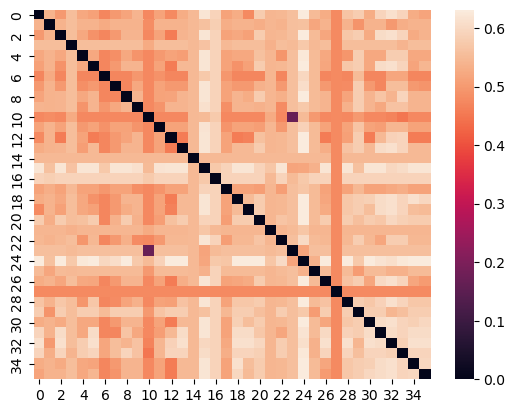

(36, 36)


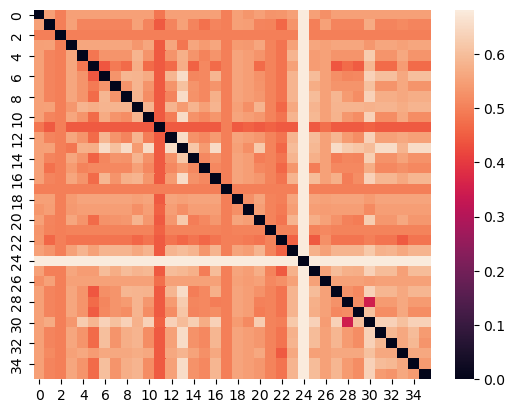

(36, 36)


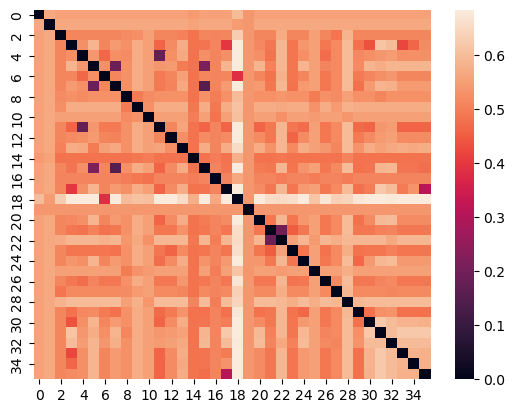

(36, 36)


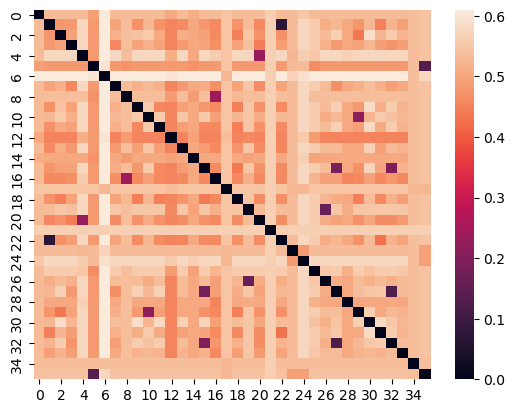

(36, 36)


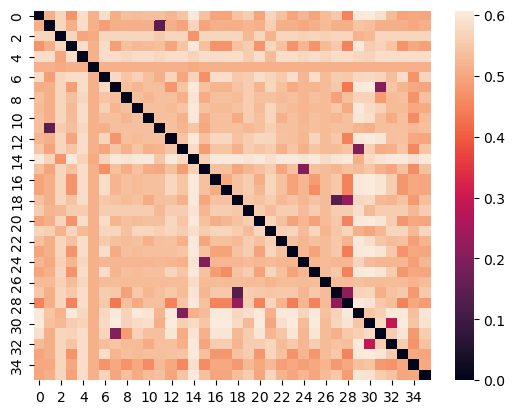

(36, 36)


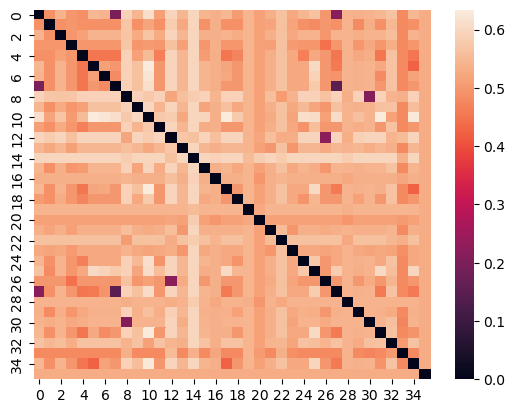

(36, 36)


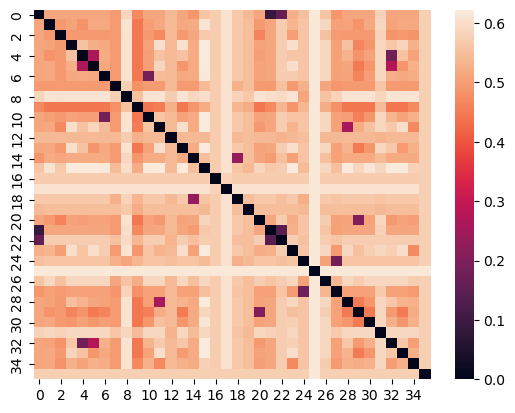

(36, 36)


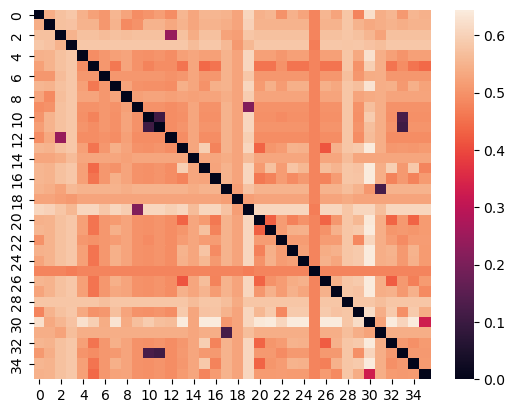

In [25]:
%matplotlib inline
for corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    sns.heatmap(1-data)
    plt.show()